In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import glob
import os

In [2]:
print('Tensorflow version: {}'.format(tf.__version__))

Tensorflow version: 2.8.0


In [3]:
train_image_path = glob.glob('dog/train/*/*.jpg')

In [4]:
len(train_image_path)

367

In [5]:
train_image_path[280:350]

['dog/train\\healthy\\ia_100010623.jpg',
 'dog/train\\healthy\\ia_100010854.jpg',
 'dog/train\\healthy\\ia_100010855.jpg',
 'dog/train\\healthy\\ia_100010857.jpg',
 'dog/train\\healthy\\ia_100010858.jpg',
 'dog/train\\healthy\\ia_100010871.jpg',
 'dog/train\\healthy\\ia_100011165.jpg',
 'dog/train\\healthy\\ia_100011306.jpg',
 'dog/train\\healthy\\ia_100011312.jpg',
 'dog/train\\healthy\\ia_100011314.jpg',
 'dog/train\\healthy\\ia_100011574.jpg',
 'dog/train\\healthy\\ia_100011581.jpg',
 'dog/train\\healthy\\ia_100011582.jpg',
 'dog/train\\unhealthy\\french_bulldog_google_107.jpg',
 'dog/train\\unhealthy\\french_bulldog_google_108.jpg',
 'dog/train\\unhealthy\\french_bulldog_google_125.jpg',
 'dog/train\\unhealthy\\french_bulldog_google_19.jpg',
 'dog/train\\unhealthy\\french_bulldog_google_26.jpg',
 'dog/train\\unhealthy\\french_bulldog_google_30.jpg',
 'dog/train\\unhealthy\\french_bulldog_google_31.jpg',
 'dog/train\\unhealthy\\french_bulldog_google_34.jpg',
 'dog/train\\unhealthy\\

In [6]:
train_image_path[-5:]

['dog/train\\unhealthy\\ia_100009834.jpg',
 'dog/train\\unhealthy\\ia_100010146.jpg',
 'dog/train\\unhealthy\\ia_100011148.jpg',
 'dog/train\\unhealthy\\ia_100011313.jpg',
 'dog/train\\unhealthy\\ia_100011584.jpg']

In [7]:
train_image_label = [int(path.split('\\')[1] == 'healthy') for path in train_image_path]

In [8]:
train_image_label[:5]

[1, 1, 1, 1, 1]

In [9]:
train_image_label[-5:]

[0, 0, 0, 0, 0]

In [10]:
def load_preprosess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    image = tf.cast(image, tf.float32)
    image = image/255
    label = tf.reshape(label, [1])
    return image, label

In [11]:
train_image_ds = tf.data.Dataset.from_tensor_slices((train_image_path, train_image_label))

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [13]:
train_image_ds = train_image_ds.map(load_preprosess_image, num_parallel_calls=AUTOTUNE)

In [14]:
train_image_ds

<ParallelMapDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(1,), dtype=tf.int32, name=None))>

In [15]:
BATCH_SIZE = 32
train_count = len(train_image_path)

In [16]:
train_image_ds = train_image_ds.shuffle(train_count).batch(BATCH_SIZE)
train_image_ds = train_image_ds.prefetch(AUTOTUNE)

In [17]:
test_image_path = glob.glob('dog/test/*/*.jpg')
test_image_label = [int(path.split('\\')[1] == 'healthy') for path in test_image_path]
test_image_ds = tf.data.Dataset.from_tensor_slices((test_image_path, test_image_label))
test_image_ds = test_image_ds.map(load_preprosess_image, num_parallel_calls=AUTOTUNE)
test_image_ds = test_image_ds.batch(BATCH_SIZE)
test_image_ds = test_image_ds.prefetch(AUTOTUNE)

In [18]:
imgs,labels=next(iter(train_image_ds))

In [19]:
imgs.shape

TensorShape([32, 256, 256, 3])

In [20]:
labels.shape

TensorShape([32, 1])

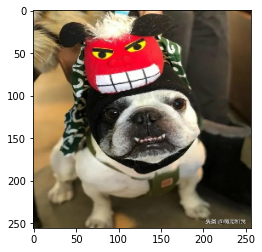

In [21]:
plt.imshow(imgs[0])

In [22]:
labels[0]

<tf.Tensor: shape=(1,), dtype=int32, numpy=array([1])>

In [23]:
from tensorflow.keras import layers

In [24]:
model = keras.Sequential()
model.add(layers.Flatten(input_shape=(256, 256, 3)))
model.add(layers.Dense(1024, activation='relu'))
tf.keras.layers.BatchNormalization()
model.add(layers.Dense(512, activation='relu'))
tf.keras.layers.BatchNormalization()
model.add(layers.Dense(256, activation='relu'))
tf.keras.layers.BatchNormalization()
model.add(layers.Dense(128, activation='relu'))
tf.keras.layers.BatchNormalization()
model.add(layers.Dense(64, activation='relu'))
tf.keras.layers.BatchNormalization()
model.add(layers.Dense(32, activation='relu'))
tf.keras.layers.BatchNormalization()
model.add(layers.Dense(16, activation='relu'))
tf.keras.layers.BatchNormalization()
model.add(layers.Dense(1))

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 196608)            0         
                                                                 
 dense (Dense)               (None, 1024)              201327616 
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 32)                2

In [26]:
tf.keras.losses.binary_crossentropy([0.,0.,1.,1.], [1.,1.,1.,1.])

<tf.Tensor: shape=(), dtype=float32, numpy=7.6666193>

In [27]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [28]:
epoch_loss_avg = tf.keras.metrics.Mean('train_loss')
train_accuracy = tf.keras.metrics.Accuracy()

epoch_loss_avg_test = tf.keras.metrics.Mean('test_loss')
test_accuracy = tf.keras.metrics.Accuracy()

In [29]:
def train_step(model, images, labels):
    with tf.GradientTape() as t:
        pred = model(images)
        loss_step = tf.keras.losses.BinaryCrossentropy(from_logits=True)(labels, pred)
    grads = t.gradient(loss_step, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    epoch_loss_avg(loss_step)
    train_accuracy(labels, tf.cast(pred>0, tf.int32))

In [30]:
def test_step(model, images, labels):
    pred = model(images, training=False)
    loss_step = tf.keras.losses.BinaryCrossentropy(from_logits=True)(labels, pred)
    epoch_loss_avg_test(loss_step)
    test_accuracy(labels, tf.cast(pred>0, tf.int32))

In [31]:
train_loss_results = []
train_acc_results = []

test_loss_results = []
test_acc_results = []

In [32]:
num_epochs = 30

In [33]:
for epoch in range(num_epochs):
    for imgs_, labels_ in train_image_ds:
        train_step(model, imgs_, labels_)
        print('.', end='')
    print()
    
    train_loss_results.append(epoch_loss_avg.result())
    train_acc_results.append(train_accuracy.result())
    
    
    for imgs_, labels_ in test_image_ds:
        test_step(model, imgs_, labels_)
        
    test_loss_results.append(epoch_loss_avg_test.result())
    test_acc_results.append(test_accuracy.result())
    
    print('Epoch:{}: loss: {:.3f}, accuracy: {:.3f}, test_loss: {:.3f}, test_accuracy: {:.3f}'.format(
        epoch + 1,
        epoch_loss_avg.result(),
        train_accuracy.result(),
        epoch_loss_avg_test.result(),
        test_accuracy.result()
    ))
    
    epoch_loss_avg.reset_states()
    train_accuracy.reset_states()
    
    epoch_loss_avg_test.reset_states()
    test_accuracy.reset_states()

............
Epoch:1: loss: 0.656, accuracy: 0.643, test_loss: 0.550, test_accuracy: 0.811
............
Epoch:2: loss: 0.522, accuracy: 0.798, test_loss: 0.520, test_accuracy: 0.811
............
Epoch:3: loss: 0.514, accuracy: 0.798, test_loss: 0.518, test_accuracy: 0.811
............
Epoch:4: loss: 0.518, accuracy: 0.798, test_loss: 0.552, test_accuracy: 0.811
............
Epoch:5: loss: 0.504, accuracy: 0.798, test_loss: 0.552, test_accuracy: 0.811
............
Epoch:6: loss: 0.503, accuracy: 0.798, test_loss: 0.572, test_accuracy: 0.811
............
Epoch:7: loss: 0.474, accuracy: 0.796, test_loss: 0.724, test_accuracy: 0.811
............
Epoch:8: loss: 0.603, accuracy: 0.698, test_loss: 0.686, test_accuracy: 0.811
............
Epoch:9: loss: 0.577, accuracy: 0.798, test_loss: 0.562, test_accuracy: 0.811
............
Epoch:10: loss: 0.513, accuracy: 0.798, test_loss: 0.548, test_accuracy: 0.811
............
Epoch:11: loss: 0.516, accuracy: 0.798, test_loss: 0.550, test_accuracy: 0.8

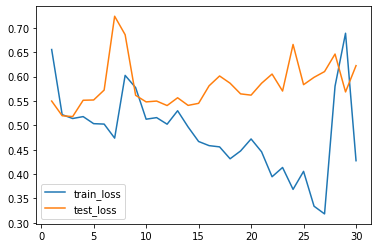

In [34]:
plt.plot(range(1,num_epochs+1),train_loss_results,label='train_loss')
plt.plot(range(1,num_epochs+1),test_loss_results,label='test_loss')
plt.legend()

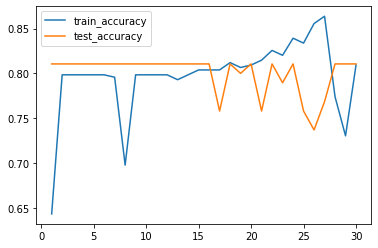

In [35]:
plt.plot(range(1,num_epochs+1),train_acc_results,label='train_accuracy')
plt.plot(range(1,num_epochs+1),test_acc_results,label='test_accuracy')
plt.legend()